In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import datasets, metrics, model_selection, svm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [3]:
data_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
data_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
target_train = data_train['TARGET']
app_train = data_train.copy()
app_test = data_test.copy()
del app_train['TARGET']
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
object_df = pd.DataFrame()
###Justify Boolean Variable,we filled out all missing values with 0 instead. 
####Justify Numbers, we filled out all missing values with average.
for f_ in app_train.columns:
    if app_train[f_].dtype == 'object':
        object_df =pd.concat([object_df,app_train[f_]],axis = 1,join = 'outer')
    else:
        if app_train[f_][(app_train[f_]!=1.0)&(app_train[f_]!=0.0)].isnull().all():
            app_train[f_][(app_train[f_]!=1.0)&(app_train[f_]!=0.0)] = 0.0
            app_test[f_][(app_test[f_]!=1.0)&(app_test[f_]!=0.0)] = 0.0
        else:
            app_train[f_][ app_train[f_].isnull()] = app_train[f_].mean()
            app_test[f_][app_test[f_].isnull()] = app_test[f_].mean()      
#             print(app_test[f_][app_test[f_].isnull()] )
print (object_df.head())
train_len = len(data_train)
data =pd.concat([app_train,app_test],axis = 0,join = 'outer')


###For variables like Weekday_Appr_Process_Start, it has more than 2 outcomes, 
###like Monday, Wednesday, and Sunday etc. We transformed this type of variable into Dummy Variables
for f_ in object_df.columns:    
    df = pd.get_dummies(data[f_], prefix = str(f_),dummy_na= False)    
    data=pd.concat([data,df],axis = 1, join= 'outer')
app_train = data.iloc[:train_len]
app_test = data.iloc[train_len:]
# print(len(app_train),len(app_test))
# print(data.columns,'\n',app_test.shape,app_train.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

  NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY NAME_TYPE_SUITE  \
0         Cash loans           M            N               Y   Unaccompanied   
1         Cash loans           F            N               N          Family   
2    Revolving loans           M            Y               Y   Unaccompanied   
3         Cash loans           F            N               Y   Unaccompanied   
4         Cash loans           M            N               Y   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0          Working  Secondary / secondary special  Single / not married   
1    State servant               Higher education               Married   
2          Working  Secondary / secondary special  Single / not married   
3          Working  Secondary / secondary special        Civil marriage   
4          Working  Secondary / secondary special  Single / not married   

   NAME_HOUSING_TYPE OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_STAR

In [5]:
for f_ in app_train.columns:
    if app_train[f_].dtype == 'object':
        del app_train[f_]
for f_ in app_test.columns:
    if app_test[f_].dtype == 'object':
        del app_test[f_]   

In [6]:
app_train.fillna(0,inplace = True)
target_train.fillna(0,inplace = True)
app_test.fillna(0,inplace = True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [7]:
### Feature Selection
### We used Principal Component Analysis (PCA) and Forward Stepwise Selection to select features.
### However, the results are all not satisfactory.

pca = PCA(n_components=100)
# X_reduced = pca.fit_transform(scale(app_train[app_train.columns[1:]]))
# X_test_reduced = pca.fit_transform(scale(app_test[app_test.columns[1:]]))
X_reduced = pd.DataFrame(scale(app_train[app_train.columns[1:]]),columns=app_train.columns[1:],index = app_train['SK_ID_CURR'])
X_test_reduced = pd.DataFrame(scale(app_test[app_test.columns[1:]]),columns=app_test.columns[1:],index = app_test['SK_ID_CURR'])
# scale(app_train)
X_test_reduced.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-0.559988,-0.427809,0.142475,-0.553684,-0.037477,-0.164654,-0.733477,-0.483656,-0.056958,1.427241,...,-0.064828,-0.173724,-0.085409,-0.077229,-0.076554,-0.548368,1.916155,-0.128681,0.928413,-0.085774
100005,-0.559988,-0.782413,-0.804537,-0.752938,-0.839362,1.009586,-0.461392,-0.498482,-1.168264,0.910437,...,-0.064828,-0.173724,-0.085409,-0.077229,-0.076554,-0.548368,-0.521878,-0.128681,-1.077107,-0.085774
100013,-0.559988,0.237075,0.401002,2.519991,0.497113,-0.147258,-0.917718,-0.498406,0.786092,-0.287579,...,-0.064828,-0.173724,-0.085409,-0.077229,-0.076554,-0.548368,-0.521878,-0.128681,-1.077107,-0.085774
100028,2.260729,1.345214,2.896221,1.223579,3.303709,0.358078,0.483623,-0.480449,0.835352,-0.736836,...,-0.064828,-0.173724,-0.085409,-0.077229,-0.076554,1.823594,-0.521878,-0.128681,0.928413,-0.085774
100038,0.850370,0.015447,0.297651,0.164921,0.483748,-0.775825,0.699997,-0.482700,0.272381,-0.771247,...,-0.064828,-0.173724,-0.085409,-0.077229,-0.076554,-0.548368,-0.521878,-0.128681,-1.077107,-0.085774


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold  1 AUC : (train): 0.747025, (val): 0.743899
[1.67501875e+00 6.75018754e-01 6.74544067e-01 ... 6.43458752e-03
 6.42456742e-03 5.59671888e-07]


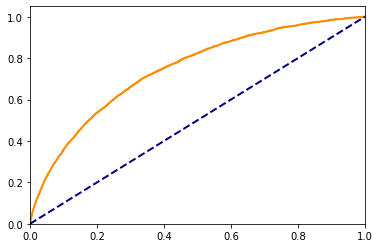

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold  2 AUC : (train): 0.746098, (val): 0.751528
[1.93934245e+00 9.39342449e-01 7.03796630e-01 ... 6.22184718e-03
 2.15305999e-04 4.60262654e-11]


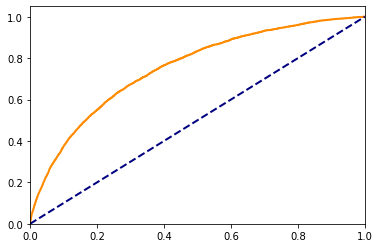

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold  3 AUC : (train): 0.747100, (val): 0.743662
[1.67461057e+00 6.74610570e-01 6.53683021e-01 ... 4.71916657e-03
 4.68714353e-03 4.29565936e-04]


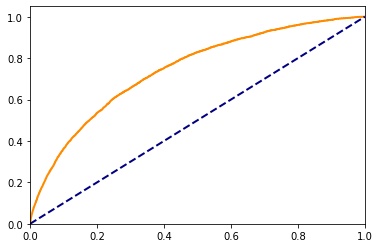

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold  4 AUC : (train): 0.748235, (val): 0.738885
[1.76254694e+00 7.62546940e-01 6.89963854e-01 ... 5.21365765e-03
 5.20568787e-03 9.16743123e-04]


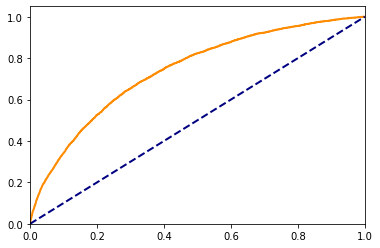

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold  5 AUC : (train): 0.747177, (val): 0.742987
[1.75820133e+00 7.58201330e-01 6.49124446e-01 ... 3.60603292e-03
 3.59865760e-03 3.30797330e-04]


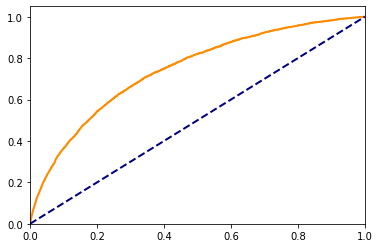

Full AUC score 0.744186


In [8]:
### In this project, in order to avoid the problem of overfitting caused by excessive number of variables. 
### We use cross-validation method to divide the original dataset into 5 groups.
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2000)
oof_preds = np.zeros(X_reduced.shape[0])
sub_preds = np.zeros(X_test_reduced.shape[0])
feature_importance_df = pd.DataFrame()
model = LogisticRegression(penalty='l2',C= 2,solver='sag',max_iter = 100)
import matplotlib.pyplot as plt

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_reduced, target_train)):
    trn_x, val_x = X_reduced.iloc[trn_idx], X_reduced.iloc[val_idx]
    trn_y, val_y = target_train.iloc[trn_idx], target_train.iloc[val_idx]
#     print(trn_x)
#     model = LogisticRegression(penalty='elasticnet',C= 0.1,solver='saga',l1_ratio = 0.5,max_iter = 200)
    
    model.fit(trn_x, trn_y)
    
    trn_y_pred = model.predict_proba(trn_x)[:,1]
    oof_preds[val_idx] = model.predict_proba(val_x)[:,1]
    sub_preds += model.predict_proba(X_test_reduced)[:,1] / folds.n_splits    
    print('Fold %2d AUC : (train): %.6f, (val): %.6f' % (n_fold + 1, 
        roc_auc_score(trn_y, trn_y_pred), roc_auc_score(val_y, oof_preds[val_idx])))
    
    fpr, tpr, thresholds = metrics.roc_curve(val_y, oof_preds[val_idx])
    roc_auc = metrics.auc(fpr,tpr)
    lw = 2
    print(thresholds)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show() 
print('Full AUC score %.6f' % roc_auc_score(target_train, oof_preds))



[1.93934245e+00 9.39342449e-01 7.58201330e-01 ... 3.59865760e-03
 5.59671888e-07 4.60262654e-11]


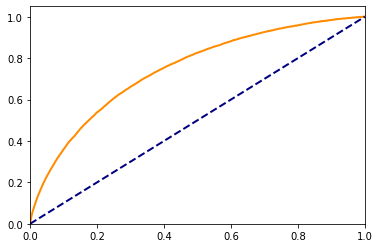

In [9]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(target_train, oof_preds)
roc_auc = metrics.auc(fpr,tpr)
lw = 2
print(thresholds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show() 
# , pos_label=2


0.08072881945686496 0.2591614608908299
[[0.76899457 0.23100543]
 [0.42022155 0.57977845]]


Text(0, 0.5, 'ture')

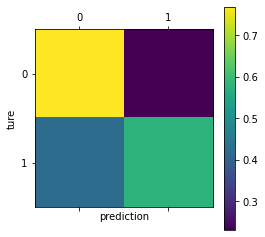

In [22]:

### A confusion matrix compares the LDA predictions to the true default statuses 
### for the 48,744 training observations in the Application_train.csv data set. 

from sklearn.metrics import confusion_matrix
ans = oof_preds.copy()
threshold = 0.1
ans[ans>threshold]=1
ans[ans<=threshold]=0
print(target_train.sum()/len(target_train),ans.sum()/len(ans))
confusion_matrix = metrics.confusion_matrix(target_train, ans)
cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
#metrics.plot_confusion_matrix(cm_normalized.T)
print(cm_normalized)
plt.matshow(cm_normalized)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('ture')

#plt.title('Normalized confusion matrix')
#disp = metrics.plot_confusion_matrix(model, X_reduced, target_train,
                             #cmap=plt.cm.Blues,
                             #normalize='true')
#disp.ax_.set_title(title)

#print(title)
#print(disp.confusion_matrix.T)
#print(tpr)



In [12]:
print(tpr)

[0.00000000e+00 0.00000000e+00 8.05639476e-05 ... 9.99959718e-01
 9.99959718e-01 1.00000000e+00]


In [13]:
#ans = oof_preds.copy()
#ans[ans>0.5]=1
#ans[ans<=0.5]=0
#ans = pd.DataFrame(ans)
#cm = metrics.confusion_matrix(target_train, ans)
#print(target_train)
#print(ans)
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#metrics.plot_confusion_matrix(cm_normalized.T)
#metrics.plot_confusion_matrix(model, X_reduced, target_train)  


In [14]:
submission_preds = pd.DataFrame(sub_preds, index = data_test['SK_ID_CURR'],columns =['TARGET'])
# submission_preds.index.astype(int)
submission_preds.to_csv('submission_preds.csv')
print(submission_preds)

              TARGET
SK_ID_CURR          
100001      0.051133
100005      0.248968
100013      0.047756
100028      0.036523
100038      0.129699
...              ...
456221      0.037237
456222      0.058426
456223      0.048503
456224      0.052234
456250      0.111844

[48744 rows x 1 columns]


In [15]:
### The results of our logistic regression model are showed below.
import statsmodels.api as sm
est = sm.OLS(target_train,app_train[app_train.columns[1:]]).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TARGET   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     90.30
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        23:25:49   Log-Likelihood:                -26264.
No. Observations:              307511   AIC:                         5.300e+04
Df Residuals:                  307277   BIC:                         5.548e+04
Df Model:                         233                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
CNT_CHILDREN                                         -0.0299      0.046     -0.645      0.519      -0.121       0.061
AMT_INCOME_TOTAL                                   4.992e-09   2.07e-09      2.409      0.016    9.31e-10    9.05e-09
AMT_CREDIT                                         1.548e-07   7.68e-09     20.161      0.000     1.4e-07     1.7e-07
AMT_ANNUITY                                        6.727e-07    5.5e-08     12.231      0.000    5.65e-07     7.8e-07
AMT_GOODS_PRICE                                   -1.829e-07   8.47e-09    -21.597      0.000      -2e-07   -1.66e-07
REGION_POPULATION_RELATIVE                            0.1691      0.043      3.921      0.000       0.085       0.254
DAYS_BIRTH                                         9.369e-08   1.81e-07      0.518      0.604   -2.61e-07    4.48e-07
DAYS_EMPLOYED                                      3.242e-06   2.55e-07     12.693      0.000    2.74e-06    3.74e-06
DAYS_REGISTRATION                                  6.123e-07   1.48e-07      4.150      0.000    3.23e-07    9.01e-07
DAYS_ID_PUBLISH                                    3.069e-06   3.38e-07      9.072      0.000    2.41e-06    3.73e-06
OWN_CAR_AGE                                           0.0003   6.93e-05      4.050      0.000       0.000       0.000
FLAG_MOBIL                                            0.0456      0.264      0.173      0.863      -0.471       0.563
FLAG_EMP_PHONE                                       -0.0383      0.076     -0.501      0.616      -0.188       0.112
FLAG_WORK_PHONE                                       0.0133      0.001      9.933      0.000       0.011       0.016
FLAG_CONT_MOBILE                                     -0.0158      0.011     -1.387      0.166      -0.038       0.007
FLAG_PHONE                                           -0.0034      0.001     -2.948      0.003      -0.006      -0.001
FLAG_EMAIL                                           -0.0052      0.002     -2.478      0.013      -0.009      -0.001
CNT_FAM_MEMBERS                                       0.0311      0.046      0.671      0.502      -0.060       0.122
REGION_RATING_CLIENT                                 -0.0092      0.003     -2.941      0.003      -0.015      -0.003
REGION_RATING_CLIENT_W_CITY                           0.0189      0.003      6.037      0.000       0.013       0.025
HOUR_APPR_PROCESS_START                           -9.293e-05      0.000     -0.594      0.553      -0.000       0.000
REG_REGION_NOT_LIVE_REGION                           -0.0171      0.006     -2.814      0.005      -0.029      -0.005
REG_REGION_NOT_WORK_REGION                            0.0043      0.007      0.660      0.510      -0.008       0.017
LIVE_REGION_NOT

In [16]:
### We tried to use XG-Boost to fit the feature vector after PCA’s dimensionality reduction.
import xgboost as xgb
# 1.Booster 参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 10,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 6,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.002,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
    'eval_metric':'auc'
}
plst = list(params.items())
# evallist = [(dtest, 'eval'), (dtrain, 'train')]   # 指定验证集

In [17]:
# 生成数据集格式
dtrain = xgb.DMatrix(X_reduced,target_train)
num_rounds = 600
# xgboost模型训练
model = xgb.train(plst,dtrain,num_rounds)
 
# 对测试集进行预测
dtest = xgb.DMatrix(X_test_reduced)
y_pred = model.predict(dtest)
 
num_round = 10
bst = xgb.train( plst, dtrain, num_round)
# 计算准确率
# accuracy = accuracy_score(y_test,y_pred)
# print('accuarcy:%.2f%%'%(accuracy*100))

### We found that there seems to be no global optimization solution with this data set. 
### As a result, our program failed to find the optimal solution of corresponding parameters and prediction models during the operation.

[23:25:51] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: 

In [ ]:
target_train = app_train[['SK_ID_CURR','TARGET']]
app_train.columns

The general steps of adjusting XG-Boost parameter:

In [ ]:
pca = PCA(n_components=30)
X_reduced = pca.fit_transform(scale(app_train[app_train.columns[1:]]))
X_test_reduced = pca.fit_transform(scale(app_test[app_test.columns[1:]]))
X_reduced = pd.DataFrame(scale(X_reduced),index = app_train['SK_ID_CURR'])
X_test_reduced = pd.DataFrame(scale(X_test_reduced),index = app_test['SK_ID_CURR'])

In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

train_x, valid_x, train_y, valid_y = train_test_split(X_reduced, target_train, test_size=0.2, random_state=1)   # 分训练集和验证集
parameters = {
              'max_depth': [5, 10, 15],
              'learning_rate': [0.01, 0.02, 0.05],
              'n_estimators': [500, 1000, 2000],
              'min_child_weight': [0, 2, 5],
              'max_delta_step': [ 0.2, 0.6],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.5, 0.6, 0.7],
              'reg_alpha': [0, 0.25, 0.5],
              'reg_lambda': [0.2, 0.4, 0.6]
#               'scale_pos_weight': [0.2, 0.4, 0.6]
}

xlf = xgb.XGBClassifier(max_depth=10,
            learning_rate=0.01,
            n_estimators=2000,
            silent=True,
            objective='multi:softmax',
            metric='multiclass',
            eval_metric='mlogloss',
            num_class=3,          
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=0,
            missing=1)

gs = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gs.fit(train_x, train_y)

print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set: %s" % gs.best_params_ )

In [ ]:
ans = gs.predict(X_test_reduced)